# 2023-06-23__Vm_traces_AdEx_Izh__Brian

In [1]:
from brian2 import *

In [2]:
defaultclock.dt

100. * usecond

In [97]:
# AdEx LIF neuron params (cortical RS from Naud 2008)
C   = 104  * pF
g_L = 4.3  * nS
E_L = -65  * mV
V_T = -52  * mV
D_T = 0.8  * mV 
Vs  =  40  * mV
Vr  = -53  * mV
a   = 0.8  * nS
b   =  65  * pA
tau_w =  88  * ms

88. * msecond

In [98]:
from scipy.special import lambertw

In [99]:
E_T = E_L - D_T * real(lambertw(-exp((E_L-V_T)/D_T), -1))

-49.63585597 * mvolt

In [211]:
k = g_L / (E_T - E_L)

k / (nS / mV)

0.2798724088953702

In [101]:
E_e = 0   * mV
E_i = -80 * mV
we = 8    * nS
wi = 8    * nS
tau = 7   * ms;

Input neurons:

In [102]:
N = 6500
# N = 500

μₓ = 4 # Hz
σ = sqrt(0.6)
μ = log(μₓ) - σ**2 / 2

1.0862943611198905

In [103]:
Ne = N * 4//5

5200

In [175]:
izh = "dV/dt = ( k*(V - E_L)*(V - E_T) -I -w) / C : volt"
adx = "dV/dt = ( -g_L*(V - E_L) + g_L * D_T * exp((V-V_T)/D_T) -I ) / C : volt"

eqs = lambda F: f"""
{F}
dw/dt = (a*(V - E_L) - w) / tau_w : amp

I = g_e * (V - E_e) + g_i * (V - E_i) : amp

dg_e/dt = -g_e / tau : siemens
dg_i/dt = -g_i / tau : siemens
"""

def network(F):
    n = NeuronGroup(1, eqs(F), threshold="V > Vs", reset="V = Vr; w += b", method='euler')
    n.V = Vᵣ
    n.w = 0 * nA
    n.g_e = 0 * nS
    n.g_i = 0 * nS
    
    rates = lognormal(μ, σ, N) * Hz;
    P = PoissonGroup(N, rates)
    
    Se = Synapses(P, n, on_pre="g_e += we")
    Si = Synapses(P, n, on_pre="g_i += wi")
    Se.connect("i < Ne")
    Si.connect("i >= Ne")
    
    M = StateMonitor(n, ["V", "I", "w"], record=0)
    S = SpikeMonitor(n)
    
    objs = [n, P, Se, Si, M, S]
    return *objs, Network(objs)

In [178]:
n, P, Se, Si, M, S, net = network(izh)

In [179]:
n

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_12')

In [180]:
net.store()

In [208]:
net.restore()

we = 0.01 * nS
wi = 4 * we

net.run(1000 * ms, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


In [284]:
%run lib/plot.py

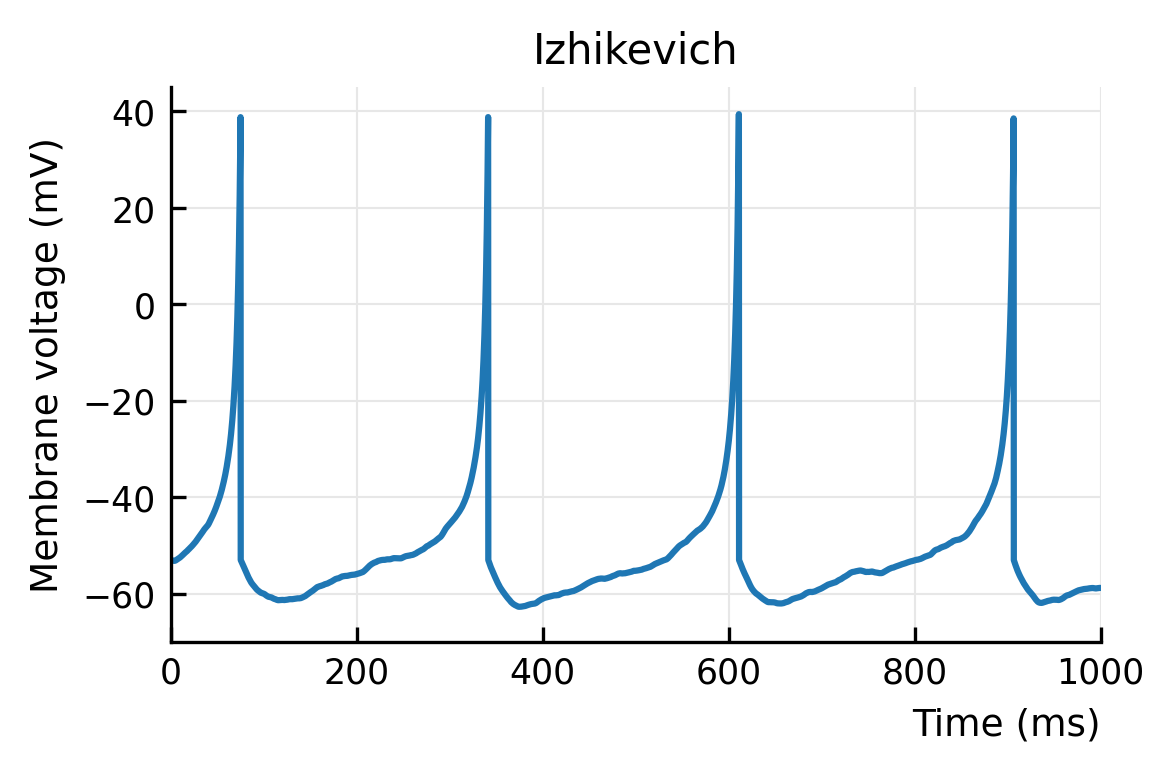

In [289]:
def plotV(V, title, ax=None):
    ax = plotsig(V, "Membrane voltage", False, ylim=[-70,45], ax=ax)
    ax.set_title(title, loc='center')
    
plotV(M.V[0], "Izhikevich")
# savefig("../thesis/figs/Vm_izh.pdf")

---

In [126]:
n, P, Se, Si, Mx, Sx, netx = network(adx)
netx.store()

In [129]:
n.equations['V']

dV/dt = (D_T*g_L*exp((V - V_T)/D_T) - I - g_L*(-E_L + V))/C : volt

In [202]:
netx.restore()

we = 0.014 * nS
wi = 4*we

netx.run(1000 * ms, report='text')

Starting simulation at t=0. s for a duration of 1. s
1. s (100%) simulated in 1s


In [169]:
def ceil_spikes_(V, t, spiketimes, V_ceil=Vs):
    i = np.searchsorted(t, spiketimes)
    V[i] = V_ceil
    return V

In [170]:
def ceil_spikes(M, S, var='V', n=0):
    V = getattr(M, var)[n]
    spikes = S.t[S.i == n]
    return ceil_spikes_(V, M.t, spikes)

In [203]:
Vx = ceil_spikes(Mx, Sx);

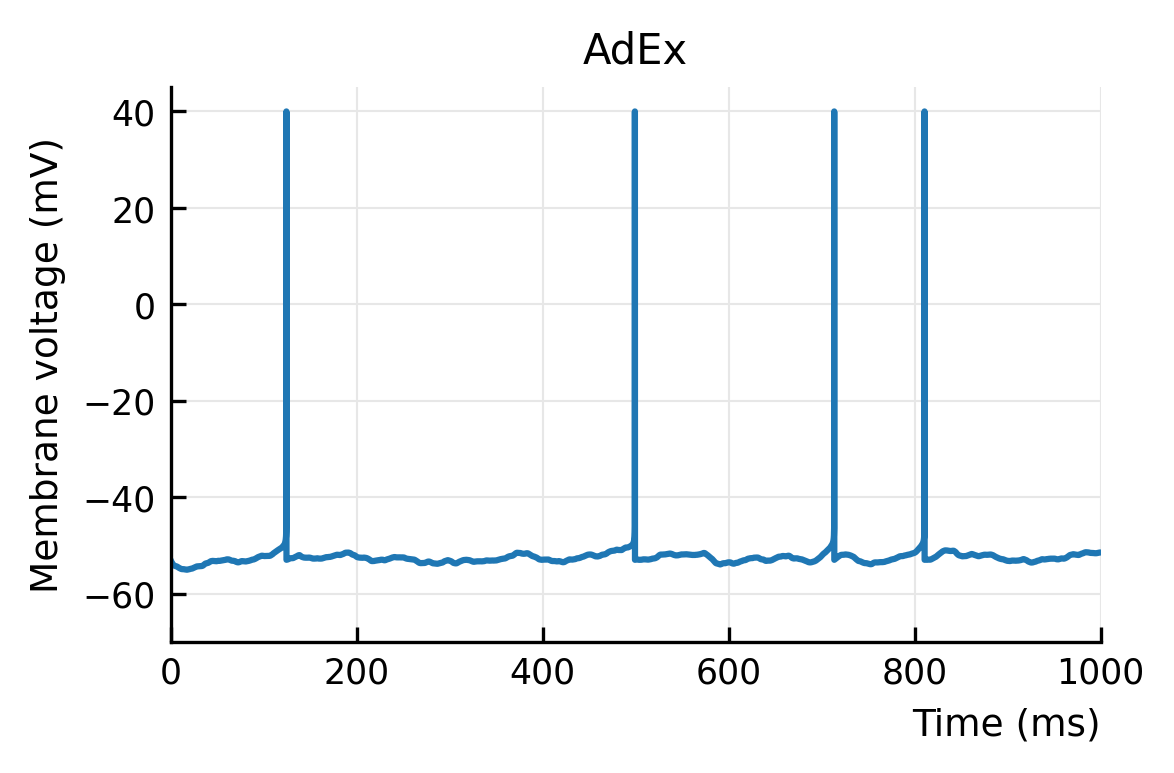

In [287]:
plotV(Vx, "AdEx")
# savefig("../thesis/figs/Vm_adx.pdf")

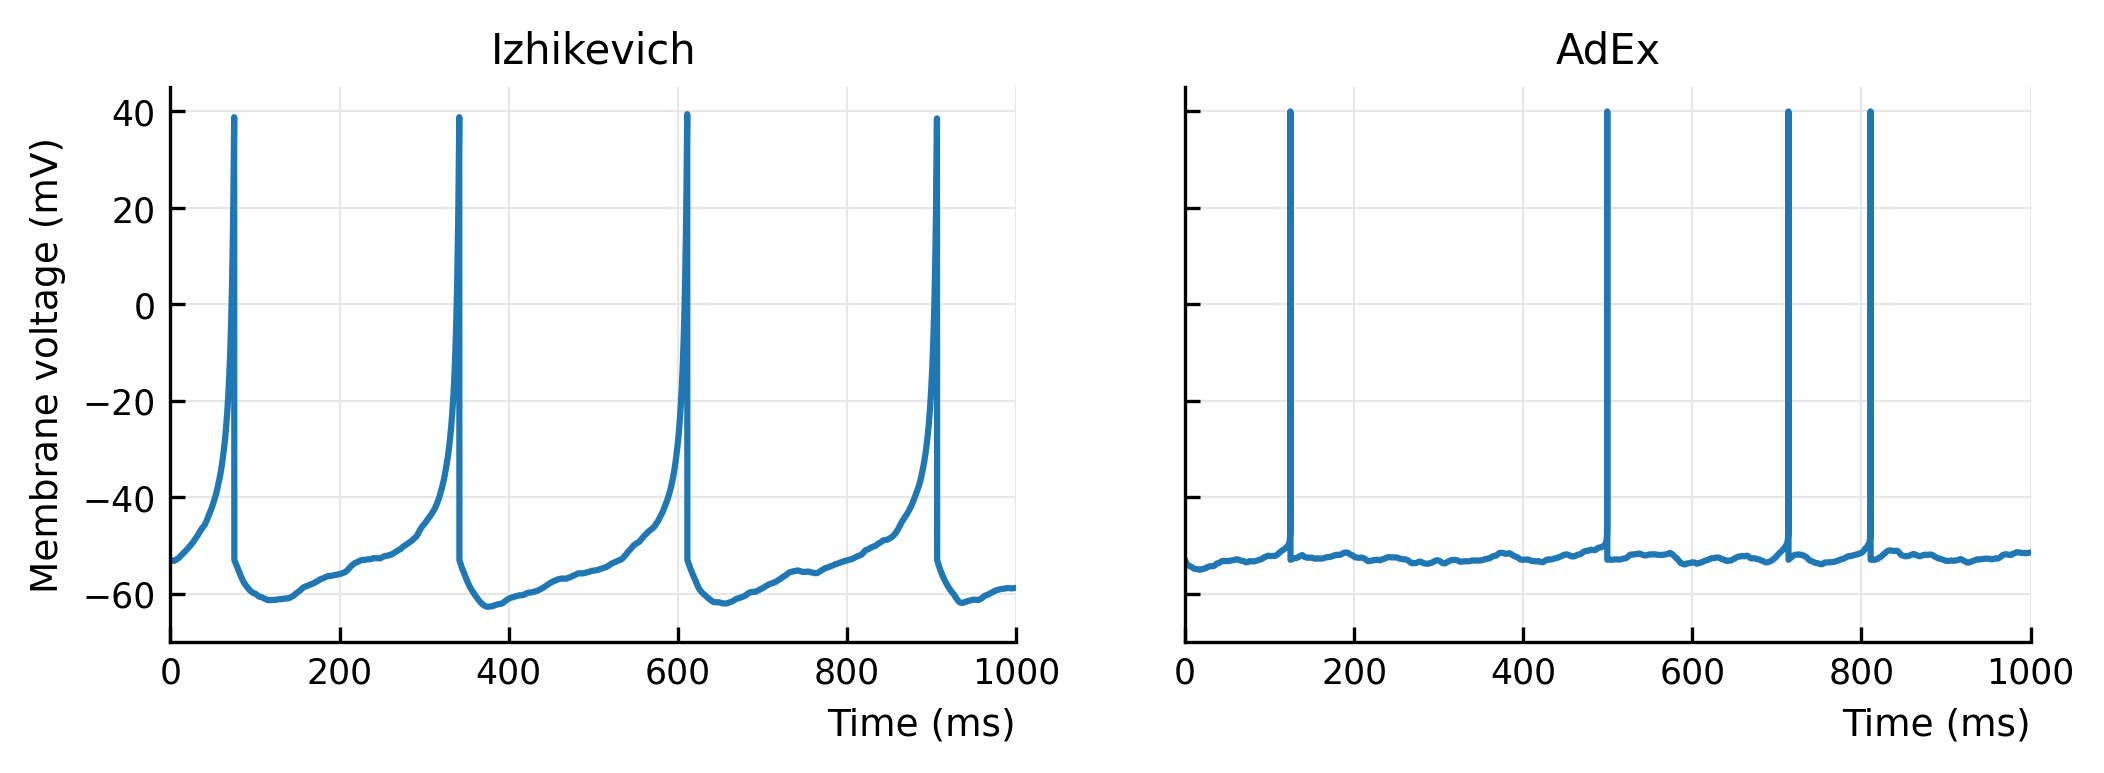

In [297]:
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 2.4))
plotV(M.V[0], "Izhikevich", ax=axs[0])
plotV(Vx, "AdEx", ax=axs[1])
axs[1].set_ylabel(None);
# plt.tight_layout()
savefig("../thesis/figs/Vm_Izh_vs_AdEx.pdf")